In [1]:
import tensorflow as tf
import tensorflow_probability as tfp
import numpy as np
import matplotlib.pyplot as plt
from tqdm import trange
tfd = tfp.distributions

In [2]:
n_train = 100
dims = 1
shape = (n_train, dims)
        

In [3]:

x_train = tf.random.normal(shape)
f = lambda x: x**2
y_train = f(x_train)

Metal device set to: Apple M1

systemMemory: 8.00 GB
maxCacheSize: 2.67 GB



2021-12-04 14:22:27.580187: I tensorflow/core/common_runtime/pluggable_device/pluggable_device_factory.cc:305] Could not identify NUMA node of platform GPU ID 0, defaulting to 0. Your kernel may not have been built with NUMA support.
2021-12-04 14:22:27.580793: I tensorflow/core/common_runtime/pluggable_device/pluggable_device_factory.cc:271] Created TensorFlow device (/job:localhost/replica:0/task:0/device:GPU:0 with 0 MB memory) -> physical PluggableDevice (device: 0, name: METAL, pci bus id: <undefined>)


In [4]:
print(y_train.shape)

(100, 1)


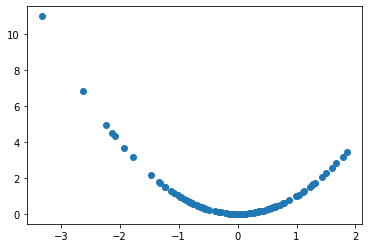

In [5]:
plt.scatter(x_train, y_train)
plt.show()

In [6]:
negloglik = lambda y, p_y: -p_y.log_prob(y)

In [7]:
#Simple model

# Build model.
model = tf.keras.Sequential([
  tf.keras.layers.Dense(1),
  tfp.layers.DistributionLambda(lambda t: tfd.Normal(loc=t, scale=1)),
])

# Do inference.
model.compile(optimizer=tf.optimizers.Adam(learning_rate=0.05), loss=negloglik)
model.fit(x_train, y_train, epochs=500, verbose=False)

# Make predictions.
x_test = tf.random.normal(shape=(100,1))
yhat = model(x_test)

2021-12-04 14:22:31.583008: I tensorflow/compiler/mlir/mlir_graph_optimization_pass.cc:185] None of the MLIR Optimization Passes are enabled (registered 2)
2021-12-04 14:22:31.585395: W tensorflow/core/platform/profile_utils/cpu_utils.cc:128] Failed to get CPU frequency: 0 Hz
2021-12-04 14:22:31.701956: I tensorflow/core/grappler/optimizers/custom_graph_optimizer_registry.cc:112] Plugin optimizer for device_type GPU is enabled.


In [8]:
print(yhat.mean())

tf.Tensor(
[[ 0.39863914]
 [ 1.306606  ]
 [ 0.5485462 ]
 [ 1.325012  ]
 [ 0.8082762 ]
 [ 0.6476904 ]
 [ 0.51209277]
 [ 1.7789958 ]
 [ 0.6229939 ]
 [-0.50911695]
 [ 0.61570394]
 [ 1.3621962 ]
 [ 0.3252589 ]
 [ 1.3208784 ]
 [ 0.90868443]
 [ 0.08602619]
 [ 0.30137962]
 [ 0.0219968 ]
 [-0.51376146]
 [ 1.1727365 ]
 [ 0.36738074]
 [ 1.8048935 ]
 [ 1.0001775 ]
 [ 1.3429244 ]
 [ 0.49280572]
 [ 2.1988215 ]
 [ 1.6113303 ]
 [ 1.0730592 ]
 [ 1.6746013 ]
 [ 0.7302741 ]
 [ 0.73703974]
 [ 0.521712  ]
 [ 0.18376285]
 [ 0.1046477 ]
 [ 1.679107  ]
 [ 0.64102805]
 [ 1.9530809 ]
 [ 0.79925466]
 [ 1.544965  ]
 [ 0.64856887]
 [ 0.63106203]
 [ 0.70655805]
 [ 0.6977221 ]
 [ 1.404062  ]
 [ 0.9637268 ]
 [ 0.9903562 ]
 [ 1.0012004 ]
 [ 1.8419346 ]
 [ 0.6417084 ]
 [ 0.5576432 ]
 [ 2.364126  ]
 [ 0.74064714]
 [ 1.098371  ]
 [ 1.3113596 ]
 [ 0.90228826]
 [ 1.1217922 ]
 [ 0.8391381 ]
 [ 0.46847448]
 [ 0.09301752]
 [ 1.4564368 ]
 [ 1.4725785 ]
 [ 1.5228823 ]
 [ 1.6125004 ]
 [ 0.08034658]
 [ 1.9833925 ]
 [ 1.2458003 ]

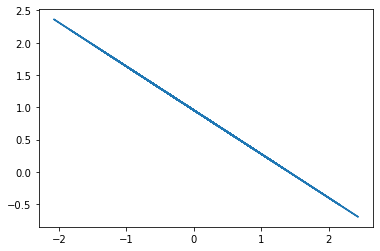

In [9]:
plt.plot(x_test, yhat.mean())
plt.show()

In [10]:
## model.layers[0].set_weights(w_prior.sample(model.layers[0].w.shape))

In [11]:
def unnormalized_log_prob(x):
    return -x**2

In [12]:
# Target distribution is proportional to: `exp(-x (1 + x))`.
def unnormalized_log_prob(x):
    return -x - x**2.

# Initialize the HMC transition kernel.
num_results = int(10e3)
num_burnin_steps = int(1e3)
adaptive_hmc = tfp.mcmc.SimpleStepSizeAdaptation(
    tfp.mcmc.HamiltonianMonteCarlo(
        target_log_prob_fn=unnormalized_log_prob,
        num_leapfrog_steps=3,
        step_size=1.),
    num_adaptation_steps=int(num_burnin_steps * 0.8))

# Run the chain (with burn-in).
@tf.function
def run_chain():
  # Run the chain (with burn-in).
    samples, is_accepted = tfp.mcmc.sample_chain(
        num_results=num_results,
        num_burnin_steps=num_burnin_steps,
        current_state=1.,
        kernel=adaptive_hmc,
        trace_fn=lambda _, pkr: pkr.inner_results.is_accepted)

    sample_mean = tf.reduce_mean(samples)
    sample_stddev = tf.math.reduce_std(samples)
    is_accepted = tf.reduce_mean(tf.cast(is_accepted, dtype=tf.float32))
    return sample_mean, sample_stddev, is_accepted


In [13]:
with tf.device("/CPU:0"):
    sample_mean, sample_stddev, is_accepted = run_chain()

2021-12-04 14:22:45.914947: I tensorflow/core/grappler/optimizers/custom_graph_optimizer_registry.cc:112] Plugin optimizer for device_type GPU is enabled.


In [15]:
print(sample_mean)
print(sample_stddev)

tf.Tensor(-0.4685812, shape=(), dtype=float32)
tf.Tensor(0.718493, shape=(), dtype=float32)


In [25]:
def g(x, a=0.89, b=2.26):
    return a*x + b

In [29]:
L = np.array([40, 60, 80, 100])
x = 1./L

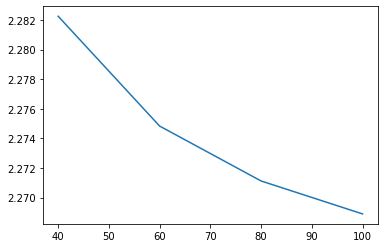

In [30]:
plt.plot(L, f(L))

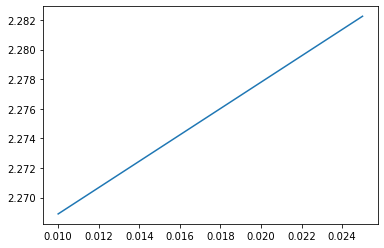

In [31]:
plt.plot(x, f(L))